In [23]:
import glob
import os
import re
import copy
from datetime import datetime
from functools import lru_cache
from functools import wraps

import nltk
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.metrics.distance import edit_distance
from nltk.stem.snowball import PorterStemmer
from scipy.sparse import find, tril
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from tabulate import tabulate
import spacy
import itertools
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
from collections import Counter

# Init help functions

In [2]:
corpus_words = np.array(words.words())
print(len(corpus_words))
vectorizer_char = CountVectorizer(analyzer='char', ngram_range=(1, 2))
nn = NearestNeighbors()
nn.fit(vectorizer_char.fit_transform(corpus_words))


@lru_cache(maxsize=300_000)
def spell_corrector(word):
    word = word.lower()
    if len(set(word)) <= 2: return word

    inx = nn.kneighbors(vectorizer_char.transform([word]), n_neighbors=200, return_distance=False)

    temp = [(edit_distance(word, w), w) for w in corpus_words[inx][0] if w[0] == word[0]]

    res = sorted(temp, key=lambda val: val[0])
    if res:
        return res[0][1]
    else:
        return word

def predict(solution, text):
    store = solution.store
    X = pd.DataFrame(text, columns=['source'])
    df =  pd.concat([pd.concat([pd.DataFrame(store['name']), pd.DataFrame(store['model'].apply(lambda x: x.predict(X.iloc[index].values.reshape(-1, 1))[0]))], axis=1).set_index('name').T for index in X.index], keys=X['source'].tolist())
    df = df.reset_index()
    return df.drop(['level_1'], axis=1).set_index('level_0').rename_axis(columns='transformation', index='source')

def as_table(head):
    def wrapper(method):
        @wraps(method)
        def _impl(self, *method_args, **method_kwargs):
                method_output = method(self, *method_args, **method_kwargs)
                display(HTML(tabulate(method_output, headers=['pipeline', *head], tablefmt='html', showindex="always")))
                return None
        return _impl
    return wrapper

236736


# Solution class

In [155]:
class Solution:

    class TweetFeatureExtractor(BaseEstimator, TransformerMixin):

        def fit(self, X, y=None):
            return self

        def transform(self, X, y=None):

            X = pd.Series(X)
            out = pd.DataFrame(
                {
                    'n_chars': X.apply(lambda x: len(x.replace(' ', ''))),
                    'n_words': X.apply(lambda x: max(x.count(' '),1)),
                    'n_numeric': X.apply(lambda x: len([i for i in x if i.isdigit()])),
                    'avg_word_len': X.apply(lambda x: sum([len(i) for i in x.split(' ')])/len(x.split(' '))),
                    'xD': X.apply(lambda x: x.count('xD')),
                    ':D': X.apply(lambda x: x.count(':D')),
                    ')': X.apply(lambda x: x.count(')')),
                    '(': X.apply(lambda x: x.count(')')),
                    '!': X.apply(lambda x: x.count('!')),
                    '!!': X.apply(lambda x: x.count('!!')),
                    '!!!': X.apply(lambda x: x.count('!!!')),
                    '.': X.apply(lambda x: x.count('.')),
                    '...': X.apply(lambda x: x.count('...')),
                    ':/': X.apply(lambda x: x.count(':/')),
                    ":'" : X.apply(lambda x: x.count(":'")),
                    ':-)': X.apply(lambda x: x.count(":-)")),
                    ':-(': X.apply(lambda x: x.count(":-(")),
                    ':(': X.apply(lambda x: x.count(":(")),
                    ':)': X.apply(lambda x: x.count(":)")),
                    '$': X.apply(lambda x: x.count("$")),
                    '*': X.apply(lambda x: x.count("*")),
                    '^': X.apply(lambda x: x.count("^")),
                    '%': X.apply(lambda x: x.count("%")),
                    '-': X.apply(lambda x: x.count("-")),
                    '+': X.apply(lambda x: x.count("+")),
                    '=': X.apply(lambda x: x.count("=")),
                    ',': X.apply(lambda x: x.count(",")),
                    '/': X.apply(lambda x: x.count("/")),
                    '_': X.apply(lambda x: x.count("_")),
                    "'": X.apply(lambda x: x.count("'")),
                    'RT': X.apply(lambda x: x.lower().count(" rt ")),
                    'TheFashionIcon': X.apply(lambda x: x.count('TheFashionIcon')),
                    'KISSES': X.apply(lambda x: x.count('KISSES')),
                    'mutual:': X.apply(lambda x: x.count('mutual:')),
                    'me:': X.apply(lambda x: x.count('me:')),
                    'n_upper': X.apply(lambda x: sum(1 for c in x if c.isupper())),

                }
            )

            out['words_to_chars_ratio'] = out['n_words'] / out['n_chars']
            out['share_upper_1'] = out['n_upper'] / out['n_chars']
            out['share_upper_2'] = out['n_upper'] / out['n_words']
            out['smile_ratio_1'] = out[')'] / out['n_words']
            out['smile_ratio_2'] = out['('] / out['n_words']

            return out

    class NERFeatureExtractor(BaseEstimator, TransformerMixin):
        ner = spacy.load('en_core_web_sm')
        def __init__(self):
            super()
            self.ent = [
                'ORG',
                'NORP',
                'CARDINAL',
                'PERSON',
                'GPE',
                'PRODUCT',
                'WORK_OF_ART',
                'PERCENT',
                'DATE',
                'TIME',
                'ORDINAL',
                'LOC',
                'MONEY',
                'FAC',
            ]

        def fit(self, X, y=None):
            return self

        def transform(self, X, y=None):
            out = pd.DataFrame(columns=self.ent)
            for text in X:
                ner_counts = Counter([word.label_ for word in self.ner(text).ents])
                for n in ['LANGUAGE', 'QUANTITY', 'EVENT', 'LAW']:
                    del ner_counts[n]

                out = pd.concat([out, pd.DataFrame([ner_counts])], ignore_index=True)

            return out.fillna(0)

    statistics = {
        'word_exist': lambda tokenizer: CountVectorizer(binary=True, tokenizer=tokenizer),
        'word_count': lambda tokenizer: CountVectorizer(tokenizer=tokenizer),
        'TFIDF': lambda tokenizer: TfidfVectorizer(tokenizer=tokenizer),
    }

    tokenizers = {
        'tweet': lambda text: TweetTokenizer().tokenize(text),
        'basic': lambda text: nltk.word_tokenize(text)
    }

    preprocessors = {
        'stemming': lambda tokens: [PorterStemmer().stem(w) for w in tokens],
        'lemmatization': lambda tokens: [nltk.stem.WordNetLemmatizer().lemmatize(w) for w in tokens],
        'stopwords': lambda tokens: [w for w in tokens if w.lower() not in stopwords.words('english')],
        'misspelling': lambda tokens: [spell_corrector(w) for w in tokens],
    }

    pipelines = {
        'just_tokenization': [],
        'stemming': [preprocessors['stemming']],
        'lemmatization': [preprocessors['lemmatization']],
        'stemming+': [preprocessors['stopwords']],
        'misspelling': [preprocessors['misspelling']],
        'lemmatization + misspelling': [preprocessors['lemmatization'], preprocessors['misspelling']],
    }

    extractor_classifiers = {
        'NER': NERFeatureExtractor(),
        'Tweet': TweetFeatureExtractor(),
    }

    models = {
        'logistic': LogisticRegression(max_iter=5000),
        'gradient': GradientBoostingClassifier(n_estimators=200),
        'forest': RandomForestClassifier(n_estimators=200, max_depth=16, n_jobs=-1)
    }


    @staticmethod
    def _read_tweet(path):
        segment = re.search(r'^processed(.*).csv', os.path.basename(path))
        df = pd.read_csv(path, header=None, dtype=str, sep='\s*,(?=\S)', engine='python').rename(
            index={0: 'tweet'}).T.dropna()
        df['tweet'] = df['tweet'].apply(lambda x: re.sub(r' +', ' ', x))
        df.dropna(inplace=True)
        df.drop_duplicates(inplace=True)
        df.loc[:, 'class'] = segment.group(1).lower()
        return df

    def __init__(self, dataset_folder, tokenizer='tweet', model='logistic'):
        self.path = os.path.join(dataset_folder, '*')
        self._read_tweets()
        self._tokenizer_name = tokenizer
        self.model_name = model
        self.store = pd.DataFrame(columns=['name', 'accuracy','time', 'model'])

    def model(self):
        return self.models[self.model_name]

    def _read_tweets(self):
        self.df = pd.concat([self._read_tweet(file) for file in glob.glob(self.path)], ignore_index=True)
        print('Data set read')
        self.df['class'].hist()

    def train_test_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.df['tweet'],
            self.df['class'],
            stratify=self.df['class'],
            test_size=0.2
        )
        print('Train dataset split to train {}, and {} entries'.format(self.X_train.shape[0], self.X_test.shape[0]))

    def tokenizer(self, text):
        return  self.tokenizers[self._tokenizer_name](text)

    def check(self, pipeline='stemming', statistic='word_count', extractor=(), extractor_name=()):
        start_time = datetime.now()

        def transform(text):
            tokens = self.tokenizer(text)
            for feat in self.pipelines[pipeline]:
                tokens = feat(tokens)
            return tokens

        pipe = Pipeline(
            [
                ('prep', ColumnTransformer(
                    [
                        (pipeline, self.statistics[statistic](transform), 0),
                        *extractor
                    ], n_jobs=1
                )),
                ('model', self.model())
            ]
        )
        pipe.fit(self.X_train.values.reshape(-1,1), self.y_train)
        y_pred = pipe.predict(self.X_test.values.reshape(-1,1))
        calc_time = (datetime.now() - start_time).total_seconds()
        accuracy = accuracy_score(self.y_test, y_pred)
        print('{}/{} ready in {} s'.format(statistic, '/'.join([pipeline, *extractor_name]), calc_time))
        self.store = pd.concat([self.store, pd.DataFrame.from_dict(
            {'name': ['/'.join([statistic, pipeline, *extractor_name])],
                              'accuracy': [accuracy],'time': [calc_time], 'model': [copy.deepcopy(pipe)]})], ignore_index=True)
        return '{:.4f}'.format(accuracy)

    def test_pipeline(self, pipeline):
        return [pipeline] + [self.check(pipeline=pipeline, statistic=s) for s in tqdm(self.statistics, desc=pipeline)]

    def test_all(self):
        self._reset_result()
        [self.test_pipeline(pipeline=pipeline) for pipeline in tqdm(self.pipelines)]

    def result(self):
        return self.store[[col for col in self.store.columns if col != 'model']]

    def _reset_result(self):
        self.store = pd.DataFrame(columns=['name', 'accuracy','time', 'model'])

    def bonus(self):
        self._reset_result()
        out  = pd.DataFrame()
        combinations_keys = [*set().union(*[[*itertools.combinations(self.extractor_classifiers, i + 1)] for i in range(len(self.extractor_classifiers))])]
        combinations = [(('_'.join(keys),), [(key, self.extractor_classifiers[key], 0) for key in keys])  for keys in combinations_keys]
        for pipeline in tqdm(self.pipelines):
            out = pd.concat([out, pd.DataFrame([self.test_pipeline(pipeline=pipeline)], columns=['pipeline\\preprocessor'] + [*self.statistics.keys()])], ignore_index=True)
            for (extractor_name, extractor) in tqdm(combinations, desc=pipeline):
                data = pd.DataFrame([
                     [pipeline] + [self.check(pipeline=pipeline, statistic=s, extractor_name=extractor_name, extractor=extractor) for s in  tqdm(self.statistics)]
                ]
                , columns=['pipeline\\preprocessor'] + ['/'.join([s, extractor_name[0]]) for s in self.statistics] ,index=out.index[out['pipeline\\preprocessor'] == pipeline])
                out = out.combine_first(data)
        out = out.reindex(columns=(['pipeline\\preprocessor'] + [a for a in out.columns if a != 'pipeline\\preprocessor'] ))
        return  out

    @as_table(['top', 'index', 'tweet'])
    def find_similar(self, statistic, top_k=10):
        model = self.statistics[statistic](self.tokenizer)
        model.fit(self.X_train)
        sim = cosine_similarity(model.transform(self.X_train), dense_output=False)
        sim.count_nonzero()

        r, c, v = find(tril(sim, k=-1))
        v = -v
        r, c = r[v.argsort()], c[v.argsort()]
        out = []
        for i in range(top_k):
            out.append([i + 1, r[i], self.X_train.iloc[r[i]]])
            out.append([i + 1, c[i], self.X_train.iloc[c[i]]])
            out.append([])
        display(HTML(tabulate(out, headers=['top', 'index', 'tweet'], tablefmt='html')))

In [156]:
pd.set_option('display.max_columns', None, 'display.max_rows', None)

# 1 Reading data

Data set read


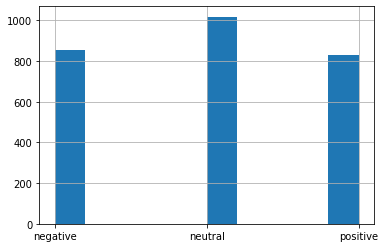

In [157]:
solution = Solution('./data', tokenizer='basic', model='gradient')

In [158]:
solution.train_test_split()

Train dataset split to train 2162, and 541 entries


## Custom Extractors

In [134]:
Solution.TweetFeatureExtractor().transform(solution.X_train)

n_chars  n_words  n_numeric  avg_word_len  xD  :D  )  (  !  !!  !!!   .  \
2203       61       11          0      5.083333   0   0  0  0  0   0    0   0   
458        78       16          1      4.588235   0   0  1  1  0   0    0   0   
2696       44       10          0      4.000000   0   0  0  0  0   0    0   2   
432         6        1          0      3.000000   0   0  0  0  0   0    0   0   
1103       29        4          0      5.800000   0   0  0  0  0   0    0   1   
546        52       10          0      4.727273   0   0  0  0  0   0    0   0   
36         82       16          0      4.823529   0   0  0  0  1   0    0   0   
1530       51       10          0      4.636364   0   0  0  0  0   0    0   1   
2201       82       18          0      4.315789   0   0  0  0  0   0    0   2   
175        44        9          0      4.400000   0   0  0  0  0   0    0   0   
364       116       23          1      4.833333   0   0  0  0  0   0    0   0   
2341       96       20          0      4.571429   0   0  0  0  3   0    0   0   
2006       57       13          0      4.071429   0   2  0  0  1   0    0   1   
2217       25        5          0      4.166667   0   0  0  0  1   0    0   0   
1617       56       13          0      4.000000   0   0  0  0  0   0    0   0   
1803       38        6          0      5.428571   0   0  0  0  0   0    0   0   
1817       76       12          0      5.846154   0   0  0  0  0   0    0   1   
923        36        5          0      6.000000   0   0  0  0  0   0    0   1   
1081       46        7          0      5.750000   0   0  0  0  0   0    0   1   
947        40       10          0      3.636364   0   0  1  1  0   0    0   1   
1756       44       11          2      3.666667   0   0  0  0  0   0    0   0   
2062       56       14          0      3.733333   0   0  1  1  0   0    0   0   
509        11        1          0      5.500000   0   0  0  0  0   0    0   0   
2566       48       11          0      4.000000   0   0  0  0  0   0    0   0   
1293       78       16          0      4.588235   0   0  0  0  0   0    0   2   
1223        2        1          2      2.000000   0   0  0  0  0   0    0   0   
536        35        9          0      3.500000   0   0  0  0  0   0    0   0   
1529       60       13          0      4.285714   0   0  0  0  0   0    0   1   
53         66       16          0      3.882353   0   0  0  0  0   0    0   0   
1380       54       11          0      4.500000   0   0  0  0  0   0    0   1   
2053       24        4          0      4.800000   0   0  0  0  0   0    0   0   
1842       56       11          2      4.666667   0   0  0  0  0   0    0   1   
233        39        8          0      4.333333   0   0  0  0  0   0    0   0   
1515       54        9          0      5.400000   0   0  0  0  0   0    0   2   
807        15        2          0      5.000000   0   0  0  0  0   0    0   0   
1096       72       11          0      6.000000   0   0  0  0  0   0    0   1   
1694       19        4          5      3.800000   0   0  0  0  0   0    0   0   
1209       27        6          0      3.857143   0   0  0  0  0   0    0   0   
1731       22        3          8      5.500000   0   0  0  0  0   0    0   1   
1625       62       10          0      5.636364   0   0  0  0  0   0    0   1   
625        63       11          2      5.250000   0   0  0  0  0   0    0   0   
1894       54       13          0      3.857143   0   0  0  0  1   0    0   0   
2379       19        4          0      3.800000   0   0  0  0  0   0    0   0   
2009       79       17          4      4.388889   0   0  0  0  3   1    1   0   
1469       53        8          0      5.888889   0   0  0  0  0   0    0   1   
1451       78       15          3      4.875000   0   0  0  0  0   0    0   0   
601        67       11          0      5.583333   0   0  0  0  0   0    0   0   
1384       67       11          6      5.583333   0   0  0  0  0   0    0   1   
1130       94       18          0    

In [135]:
Solution.NERFeatureExtractor().transform(solution.X_train)

ORG  NORP  CARDINAL  PERSON  GPE  PRODUCT  WORK_OF_ART  PERCENT  DATE  \
0       0     0         0       0    0        0            0        0     1   
1       0     0         1       0    0        0            0        0     0   
2       0     0         0       0    0        0            0        0     0   
3       1     0         0       0    0        0            0        0     0   
4       0     0         0       0    0        0            0        0     0   
5       0     0         0       0    0        0            0        0     0   
6       1     0         0       0    1        0            0        0     0   
7       1     0         0       0    0        0            0        0     0   
8       0     0         0       0    0        0            1        0     0   
9       0     0         0       0    0        0            0        0     0   
10      0     0         1       0    0        0            0        0     0   
11      0     0         0       0    0        0            0        0     1   
12      0     0         0       0    0        0            1        0     0   
13      0     0         0       0    0        0            0        0     1   
14      0     0         0       1    0        0            0        0     0   
15      0     0         0       0    1        0            0        0     0   
16      0     0         0       0    0        0            0        0     0   
17      0     0         0       0    0        0            0        0     0   
18      0     0         0       0    0        0            0        0     0   
19      0     0         0       0    0        0            0        0     0   
20      1     0         1       0    0        0            0        0     0   
21      0     0         0       0    0        0            0        0     0   
22      0     0         0       0    0        0            0        0     0   
23      0     0         0       0    0        0            0        0     0   
24      2     0         0       1    0        0            0        0     0   
25      0     0         1       0    0        0            0        0     0   
26      0     0         0       0    0        0            0        0     0   
27      0     0         0       0    0        0            0        0     0   
28      0     0         0       0    0        0            0        0     0   
29      1     0         0       2    0        0            0        0     0   
30      0     0         0       0    0        0            0        0     0   
31      1     0         0       0    0        0            0        0     1   
32      0     0         0       0    0        0            0        0     0   
33      0     1         0       0    0        0            0        0     0   
34      0     0         0       0    0        0            0        0     0   
35      0     0         0       0    0        0            0        0     0   
36      0     0         1       0    0        0            0        0     0   
37      0     0         0       0    0        0            0        0     0   
38      0     0         0       0    0        0            0        0     2   
39      0     0         0       0    1        0            0        0     0   
40      0     0         1       0    0        0            0        0     0   
41      0     0         0       0    0        0            0        0     0   
42      0     0         0       0    0        0            0        0     0   
43      3     0         0       0    0        0            0        0     0   
44      0     0         0       0    0        0            0        0     0   
45      1     0         2       0    0        0            0        0     0   
46      0     0         0       0    0        0            0        0     0   
47      1     0         4       0    0        0            0        0     0   
48      0     1         0       0    0        0            0        0     1   
49      0     0         0       0    0        0         

# 2 Similar

In [136]:
%%capture --no-display
solution.find_similar('word_exist')

In [137]:
solution.find_similar('word_count')

In [138]:
solution.find_similar('TFIDF')

# 3 Machine Learning

In [139]:
solution.test_all()

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 2.501986 s
word_count/just_tokenization ready in 2.626184 s
TFIDF/just_tokenization ready in 3.952702 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 2.887404 s
word_count/stemming ready in 2.974108 s
TFIDF/stemming ready in 4.470672 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 2.584169 s
word_count/lemmatization ready in 2.597458 s
TFIDF/lemmatization ready in 4.008162 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 6.423656 s
word_count/stemming+ ready in 6.519722 s
TFIDF/stemming+ ready in 7.081072 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 2.410951 s
word_count/misspelling ready in 2.436726 s
TFIDF/misspelling ready in 3.813105 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 2.578856 s
word_count/lemmatization + misspelling ready in 2.547169 s
TFIDF/lemmatization + misspelling ready in 3.916289 s
Done !


In [140]:
solution.result().sort_values(by=['accuracy'], ascending=False)

name  accuracy      time
15  word_exist/lemmatization + misspelling  0.927911  2.578856
0             word_exist/just_tokenization  0.926063  2.501986
2                  TFIDF/just_tokenization  0.926063  3.952702
6                 word_exist/lemmatization  0.926063  2.584169
7                 word_count/lemmatization  0.926063  2.597458
3                      word_exist/stemming  0.924214  2.887404
16  word_count/lemmatization + misspelling  0.924214  2.547169
14                       TFIDF/misspelling  0.924214  3.813105
1             word_count/just_tokenization  0.924214  2.626184
12                  word_exist/misspelling  0.922366  2.410951
17       TFIDF/lemmatization + misspelling  0.922366  3.916289
5                           TFIDF/stemming  0.922366  4.470672
13                  word_count/misspelling  0.920518  2.436726
4                      word_count/stemming  0.920518  2.974108
8                      TFIDF/lemmatization  0.916821  4.008162
10                    word_count/stemming+  0.903882  6.519722
9                     word_exist/stemming+  0.903882  6.423656
11                         TFIDF/stemming+  0.900185  7.081072

In [141]:
example = ["School 21 is the best school. I am very happy that I entered and study in it.", 
           "BREAKING: Indias December quarter GDP at 7 percent (Reuters forecast was 6.4 percent) ", 
           "Ministers of PMLN are happy like those students who never studied for exams  luckily exams got delayed.", 
           "Not surprised that I have the least amount of followers out of the whole cast sad  LOL"]
solution_predict = predict(solution, example)
solution_predict

transformation                                     word_exist/just_tokenization  \
source                                                                            
School 21 is the best school. I am very happy t...                     positive   
BREAKING: Indias December quarter GDP at 7 perc...                      neutral   
Ministers of PMLN are happy like those students...                     positive   
Not surprised that I have the least amount of f...                     negative   

transformation                                     word_count/just_tokenization  \
source                                                                            
School 21 is the best school. I am very happy t...                     positive   
BREAKING: Indias December quarter GDP at 7 perc...                      neutral   
Ministers of PMLN are happy like those students...                     positive   
Not surprised that I have the least amount of f...                     negative   

transformation                                     TFIDF/just_tokenization  \
source                                                                       
School 21 is the best school. I am very happy t...                positive   
BREAKING: Indias December quarter GDP at 7 perc...                 neutral   
Ministers of PMLN are happy like those students...                positive   
Not surprised that I have the least amount of f...                negative   

transformation                                     word_exist/stemming  \
source                                                                   
School 21 is the best school. I am very happy t...            positive   
BREAKING: Indias December quarter GDP at 7 perc...             neutral   
Ministers of PMLN are happy like those students...            positive   
Not surprised that I have the least amount of f...            negative   

transformation                                     word_count/stemming  \
source                                                                   
School 21 is the best school. I am very happy t...            positive   
BREAKING: Indias December quarter GDP at 7 perc...             neutral   
Ministers of PMLN are happy like those students...            positive   
Not surprised that I have the least amount of f...            negative   

transformation                                     TFIDF/stemming  \
source                                                              
School 21 is the best school. I am very happy t...       positive   
BREAKING: Indias December quarter GDP at 7 perc...        neutral   
Ministers of PMLN are happy like those students...       positive   
Not surprised that I have the least amount of f...       negative   

transformation                                     word_exist/lemmatization  \
source                                                                        
School 21 is the best school. I am very happy t...                 positive   
BREAKING: Indias December quarter GDP at 7 perc...                  neutral   
Ministers of PMLN are happy like those students...                 positive   
Not surprised that I have the least amount of f...                 negative   

transformation                                     word_count/lemmatization  \
source                                                                        
School 21 is the best school. I am very happy t...                 positive   
BREAKING: Indias December quarter GDP at 7 perc...                  neutral   
Ministers of PMLN are happy like those students...                 positive   
Not surprised that I have the least amount of f...                 negative   

transformation                                     TFIDF/lemmatization  \
source                                                                   
School 21 is the best school. I am very happy t...            positive   
BREAKING: Indias December quarter GDP at 7 perc...      

In [142]:
%%time
# logistic = Solution('./data', tokenizer='basic', model='logistic')
# logistic.train_test_split()
solution.model_name = 'logistic'
solution.test_all()
display(solution.result().sort_values(by=['accuracy'], ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 0.418257 s
word_count/just_tokenization ready in 0.439266 s
TFIDF/just_tokenization ready in 0.432509 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 0.967555 s
word_count/stemming ready in 0.984024 s
TFIDF/stemming ready in 1.009862 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 0.573459 s
word_count/lemmatization ready in 0.593118 s
TFIDF/lemmatization ready in 0.903737 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 4.692181 s
word_count/stemming+ ready in 4.718209 s
TFIDF/stemming+ ready in 4.67923 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 0.426052 s
word_count/misspelling ready in 0.442765 s
TFIDF/misspelling ready in 0.473237 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 0.561357 s
word_count/lemmatization + misspelling ready in 0.54126 s
TFIDF/lemmatization + misspelling ready in 0.563431 s
Done !


name  accuracy      time
0             word_exist/just_tokenization  0.924214  0.418257
2                  TFIDF/just_tokenization  0.924214  0.432509
6                 word_exist/lemmatization  0.922366  0.573459
12                  word_exist/misspelling  0.922366  0.426052
17       TFIDF/lemmatization + misspelling  0.922366  0.563431
3                      word_exist/stemming  0.922366  0.967555
14                       TFIDF/misspelling  0.920518  0.473237
15  word_exist/lemmatization + misspelling  0.920518  0.561357
8                      TFIDF/lemmatization  0.918669  0.903737
9                     word_exist/stemming+  0.916821  4.692181
5                           TFIDF/stemming  0.914972  1.009862
7                 word_count/lemmatization  0.914972  0.593118
13                  word_count/misspelling  0.914972  0.442765
16  word_count/lemmatization + misspelling  0.914972   0.54126
1             word_count/just_tokenization  0.913124  0.439266
4                      word_count/stemming  0.909427  0.984024
10                    word_count/stemming+  0.900185  4.718209
11                         TFIDF/stemming+  0.898336   4.67923

CPU times: total: 23.2 s
Wall time: 23.7 s


In [143]:
%%time
# gradient = Solution('./data', tokenizer='basic', model='gradient')
# gradient.train_test_split()
solution.model_name = 'gradient'
solution.test_all()
display(solution.result().sort_values(by=['accuracy'], ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 2.730112 s
word_count/just_tokenization ready in 2.760892 s
TFIDF/just_tokenization ready in 4.846804 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 3.144732 s
word_count/stemming ready in 3.076644 s
TFIDF/stemming ready in 5.438833 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 2.78089 s
word_count/lemmatization ready in 2.796062 s
TFIDF/lemmatization ready in 4.769197 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 6.65289 s
word_count/stemming+ ready in 6.596757 s
TFIDF/stemming+ ready in 7.751713 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 2.571155 s
word_count/misspelling ready in 2.497848 s
TFIDF/misspelling ready in 4.685857 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 2.44404 s
word_count/lemmatization + misspelling ready in 2.721943 s
TFIDF/lemmatization + misspelling ready in 4.864092 s
Done !


name  accuracy      time
15  word_exist/lemmatization + misspelling  0.927911   2.44404
12                  word_exist/misspelling  0.926063  2.571155
3                      word_exist/stemming  0.926063  3.144732
16  word_count/lemmatization + misspelling  0.926063  2.721943
7                 word_count/lemmatization  0.926063  2.796062
2                  TFIDF/just_tokenization  0.924214  4.846804
6                 word_exist/lemmatization  0.924214   2.78089
13                  word_count/misspelling  0.924214  2.497848
0             word_exist/just_tokenization  0.922366  2.730112
14                       TFIDF/misspelling  0.922366  4.685857
17       TFIDF/lemmatization + misspelling  0.922366  4.864092
8                      TFIDF/lemmatization  0.922366  4.769197
4                      word_count/stemming  0.922366  3.076644
1             word_count/just_tokenization  0.920518  2.760892
5                           TFIDF/stemming  0.920518  5.438833
10                    word_count/stemming+  0.907579  6.596757
9                     word_exist/stemming+  0.907579   6.65289
11                         TFIDF/stemming+  0.900185  7.751713

CPU times: total: 1min 13s
Wall time: 1min 13s


In [144]:
%%time
# forest = Solution('./data', tokenizer='basic', model='forest')
# forest.train_test_split()
solution.model_name = 'forest'
solution.test_all()
display(solution.result().sort_values(by=['accuracy'], ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 0.54699 s
word_count/just_tokenization ready in 0.527582 s
TFIDF/just_tokenization ready in 0.57286 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 1.066231 s
word_count/stemming ready in 1.088059 s
TFIDF/stemming ready in 1.182551 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 0.718186 s
word_count/lemmatization ready in 0.622991 s
TFIDF/lemmatization ready in 0.687137 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 4.910916 s
word_count/stemming+ ready in 4.868024 s
TFIDF/stemming+ ready in 4.798437 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 0.54595 s
word_count/misspelling ready in 0.548996 s
TFIDF/misspelling ready in 0.55132 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 0.667107 s
word_count/lemmatization + misspelling ready in 0.647311 s
TFIDF/lemmatization + misspelling ready in 0.670486 s
Done !


name  accuracy      time
14                       TFIDF/misspelling  0.916821   0.55132
15  word_exist/lemmatization + misspelling  0.916821  0.667107
4                      word_count/stemming  0.914972  1.088059
6                 word_exist/lemmatization  0.914972  0.718186
12                  word_exist/misspelling  0.913124   0.54595
13                  word_count/misspelling  0.913124  0.548996
0             word_exist/just_tokenization  0.911275   0.54699
3                      word_exist/stemming  0.911275  1.066231
5                           TFIDF/stemming  0.911275  1.182551
10                    word_count/stemming+  0.911275  4.868024
16  word_count/lemmatization + misspelling  0.909427  0.647311
11                         TFIDF/stemming+  0.909427  4.798437
2                  TFIDF/just_tokenization  0.907579   0.57286
1             word_count/just_tokenization  0.907579  0.527582
7                 word_count/lemmatization  0.903882  0.622991
8                      TFIDF/lemmatization  0.902033  0.687137
17       TFIDF/lemmatization + misspelling  0.900185  0.670486
9                     word_exist/stemming+  0.890943  4.910916

CPU times: total: 30.7 s
Wall time: 25.7 s


In [145]:
%%time
# logistic = Solution('./data', tokenizer='tweet', model='logistic')
# logistic.train_test_split()
solution._tokenizer_name = 'tweet'
solution.model_name = 'logistic'
solution.test_all()
display(solution.result().sort_values(by=['accuracy'], ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 0.311861 s
word_count/just_tokenization ready in 0.326742 s
TFIDF/just_tokenization ready in 0.342236 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 0.808837 s
word_count/stemming ready in 0.897954 s
TFIDF/stemming ready in 0.905375 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 0.393412 s
word_count/lemmatization ready in 0.437246 s
TFIDF/lemmatization ready in 0.4219 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 4.431737 s
word_count/stemming+ ready in 4.394235 s
TFIDF/stemming+ ready in 4.434176 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 0.309876 s
word_count/misspelling ready in 0.318773 s
TFIDF/misspelling ready in 0.356663 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 0.41359 s
word_count/lemmatization + misspelling ready in 0.688792 s
TFIDF/lemmatization + misspelling ready in 0.451987 s
Done !


name  accuracy      time
13                  word_count/misspelling  0.927911  0.318773
1             word_count/just_tokenization  0.926063  0.326742
4                      word_count/stemming  0.926063  0.897954
16  word_count/lemmatization + misspelling  0.922366  0.688792
7                 word_count/lemmatization  0.922366  0.437246
9                     word_exist/stemming+  0.920518  4.431737
14                       TFIDF/misspelling  0.918669  0.356663
12                  word_exist/misspelling  0.918669  0.309876
10                    word_count/stemming+  0.918669  4.394235
0             word_exist/just_tokenization  0.918669  0.311861
8                      TFIDF/lemmatization  0.918669    0.4219
6                 word_exist/lemmatization  0.918669  0.393412
3                      word_exist/stemming  0.918669  0.808837
5                           TFIDF/stemming  0.916821  0.905375
17       TFIDF/lemmatization + misspelling  0.916821  0.451987
15  word_exist/lemmatization + misspelling  0.914972   0.41359
11                         TFIDF/stemming+  0.913124  4.434176
2                  TFIDF/just_tokenization  0.913124  0.342236

CPU times: total: 20.3 s
Wall time: 20.9 s


In [146]:
%%time
# gradient = Solution('./data', tokenizer='tweet', model='gradient')
# gradient.train_test_split()
solution.model_name = 'gradient'
solution.test_all()
display(solution.result().sort_values(by=['accuracy'], ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 2.623892 s
word_count/just_tokenization ready in 2.726499 s
TFIDF/just_tokenization ready in 4.641671 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 2.896601 s
word_count/stemming ready in 3.014569 s
TFIDF/stemming ready in 5.085503 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 2.558022 s
word_count/lemmatization ready in 2.699789 s
TFIDF/lemmatization ready in 4.641223 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 6.275061 s
word_count/stemming+ ready in 6.313736 s
TFIDF/stemming+ ready in 7.549862 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 2.435251 s
word_count/misspelling ready in 2.468706 s
TFIDF/misspelling ready in 4.509355 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 2.482962 s
word_count/lemmatization + misspelling ready in 2.547013 s
TFIDF/lemmatization + misspelling ready in 4.581191 s
Done !


name  accuracy      time
8                      TFIDF/lemmatization  0.926063  4.641223
16  word_count/lemmatization + misspelling  0.924214  2.547013
15  word_exist/lemmatization + misspelling  0.924214  2.482962
2                  TFIDF/just_tokenization  0.922366  4.641671
13                  word_count/misspelling  0.922366  2.468706
9                     word_exist/stemming+  0.920518  6.275061
12                  word_exist/misspelling  0.920518  2.435251
4                      word_count/stemming  0.920518  3.014569
5                           TFIDF/stemming  0.920518  5.085503
14                       TFIDF/misspelling  0.920518  4.509355
1             word_count/just_tokenization  0.920518  2.726499
0             word_exist/just_tokenization  0.918669  2.623892
7                 word_count/lemmatization  0.918669  2.699789
3                      word_exist/stemming  0.918669  2.896601
17       TFIDF/lemmatization + misspelling  0.918669  4.581191
6                 word_exist/lemmatization  0.916821  2.558022
11                         TFIDF/stemming+  0.914972  7.549862
10                    word_count/stemming+  0.914972  6.313736

CPU times: total: 1min 10s
Wall time: 1min 10s


In [147]:
%%time
# forest = Solution('./data', tokenizer='tweet', model='forest')
# forest.train_test_split()
solution.model_name = 'forest'
solution.test_all()
display(solution.result().sort_values(by=['accuracy'], ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 0.40584 s
word_count/just_tokenization ready in 0.40216 s
TFIDF/just_tokenization ready in 0.420106 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 0.984685 s
word_count/stemming ready in 0.957383 s
TFIDF/stemming ready in 0.924736 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 0.526051 s
word_count/lemmatization ready in 0.535643 s
TFIDF/lemmatization ready in 0.525021 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 4.615594 s
word_count/stemming+ ready in 4.557053 s
TFIDF/stemming+ ready in 4.499375 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 0.416334 s
word_count/misspelling ready in 0.409078 s
TFIDF/misspelling ready in 0.429272 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 0.534437 s
word_count/lemmatization + misspelling ready in 0.512092 s
TFIDF/lemmatization + misspelling ready in 0.555631 s
Done !


name  accuracy      time
11                         TFIDF/stemming+  0.913124  4.499375
5                           TFIDF/stemming  0.911275  0.924736
4                      word_count/stemming  0.907579  0.957383
17       TFIDF/lemmatization + misspelling   0.90573  0.555631
12                  word_exist/misspelling   0.90573  0.416334
13                  word_count/misspelling  0.903882  0.409078
16  word_count/lemmatization + misspelling  0.903882  0.512092
15  word_exist/lemmatization + misspelling  0.903882  0.534437
2                  TFIDF/just_tokenization  0.902033  0.420106
6                 word_exist/lemmatization  0.902033  0.526051
7                 word_count/lemmatization  0.902033  0.535643
1             word_count/just_tokenization  0.898336   0.40216
14                       TFIDF/misspelling  0.898336  0.429272
9                     word_exist/stemming+  0.896488  4.615594
10                    word_count/stemming+  0.896488  4.557053
3                      word_exist/stemming  0.896488  0.984685
0             word_exist/just_tokenization   0.89464   0.40584
8                      TFIDF/lemmatization  0.890943  0.525021

CPU times: total: 27.2 s
Wall time: 22.7 s


# 4 Bonus

In [159]:
%%time
solution.model_name = 'logistic'
solution._tokenizer_name = 'tweet'
solution.bonus()
display(solution.result().sort_values(by=['accuracy'], ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 0.306466 s
word_count/just_tokenization ready in 0.334623 s
TFIDF/just_tokenization ready in 0.319216 s


just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization/NER ready in 15.485347 s
word_count/just_tokenization/NER ready in 14.705564 s
TFIDF/just_tokenization/NER ready in 14.745441 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization/NER_Tweet ready in 17.743492 s
word_count/just_tokenization/NER_Tweet ready in 18.285107 s
TFIDF/just_tokenization/NER_Tweet ready in 21.103288 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization/Tweet ready in 4.017485 s
word_count/just_tokenization/Tweet ready in 3.862233 s
TFIDF/just_tokenization/Tweet ready in 6.218813 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 0.787541 s
word_count/stemming ready in 0.819117 s
TFIDF/stemming ready in 0.850028 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming/NER ready in 15.21617 s
word_count/stemming/NER ready in 15.205442 s
TFIDF/stemming/NER ready in 15.190097 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming/NER_Tweet ready in 18.199052 s
word_count/stemming/NER_Tweet ready in 18.328162 s
TFIDF/stemming/NER_Tweet ready in 20.301356 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming/Tweet ready in 3.959452 s
word_count/stemming/Tweet ready in 3.986062 s
TFIDF/stemming/Tweet ready in 6.386191 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 0.410957 s
word_count/lemmatization ready in 0.41506 s
TFIDF/lemmatization ready in 0.450105 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization/NER ready in 15.013359 s
word_count/lemmatization/NER ready in 14.871853 s
TFIDF/lemmatization/NER ready in 14.840306 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization/NER_Tweet ready in 18.270732 s
word_count/lemmatization/NER_Tweet ready in 18.666805 s
TFIDF/lemmatization/NER_Tweet ready in 20.120463 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization/Tweet ready in 3.670513 s
word_count/lemmatization/Tweet ready in 3.905927 s
TFIDF/lemmatization/Tweet ready in 6.114397 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 4.413079 s
word_count/stemming+ ready in 4.47241 s
TFIDF/stemming+ ready in 4.395673 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+/NER ready in 18.754252 s
word_count/stemming+/NER ready in 18.658981 s
TFIDF/stemming+/NER ready in 18.683791 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+/NER_Tweet ready in 22.391084 s
word_count/stemming+/NER_Tweet ready in 22.311711 s
TFIDF/stemming+/NER_Tweet ready in 24.353879 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+/Tweet ready in 8.016513 s
word_count/stemming+/Tweet ready in 8.211004 s
TFIDF/stemming+/Tweet ready in 9.723012 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 0.309375 s
word_count/misspelling ready in 0.308106 s
TFIDF/misspelling ready in 0.328552 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling/NER ready in 15.473199 s
word_count/misspelling/NER ready in 14.850347 s
TFIDF/misspelling/NER ready in 14.867965 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling/NER_Tweet ready in 17.958946 s
word_count/misspelling/NER_Tweet ready in 18.124362 s
TFIDF/misspelling/NER_Tweet ready in 20.293974 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling/Tweet ready in 3.561167 s
word_count/misspelling/Tweet ready in 3.612559 s
TFIDF/misspelling/Tweet ready in 5.894254 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 0.434066 s
word_count/lemmatization + misspelling ready in 0.447602 s
TFIDF/lemmatization + misspelling ready in 0.410199 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling/NER ready in 14.814421 s
word_count/lemmatization + misspelling/NER ready in 14.873134 s
TFIDF/lemmatization + misspelling/NER ready in 14.952953 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling/NER_Tweet ready in 17.864647 s
word_count/lemmatization + misspelling/NER_Tweet ready in 18.034064 s
TFIDF/lemmatization + misspelling/NER_Tweet ready in 20.429939 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling/Tweet ready in 3.897439 s
word_count/lemmatization + misspelling/Tweet ready in 3.88585 s
TFIDF/lemmatization + misspelling/Tweet ready in 5.993022 s


name  accuracy       time
44                         TFIDF/stemming+/NER_Tweet  0.933457  24.353879
14                                    TFIDF/stemming  0.931608   0.850028
22                         word_count/stemming/Tweet  0.931608   3.986062
41                               TFIDF/stemming+/NER  0.931608  18.683791
38                                   TFIDF/stemming+  0.931608   4.395673
65             TFIDF/lemmatization + misspelling/NER   0.92976  14.952953
53                             TFIDF/misspelling/NER   0.92976  14.867965
7             word_count/just_tokenization/NER_Tweet   0.92976  18.285107
34                    word_count/lemmatization/Tweet   0.92976   3.905927
18                     word_exist/stemming/NER_Tweet   0.92976  18.199052
17                                TFIDF/stemming/NER   0.92976  15.190097
31                word_count/lemmatization/NER_Tweet   0.92976  18.666805
50                                 TFIDF/misspelling   0.92976   0.328552
26                               TFIDF/lemmatization  0.927911   0.450105
36                              word_exist/stemming+  0.927911   4.413079
29                           TFIDF/lemmatization/NER  0.927911  14.840306
30                word_exist/lemmatization/NER_Tweet  0.927911  18.270732
21                         word_exist/stemming/Tweet  0.927911   3.959452
62                 TFIDF/lemmatization + misspelling  0.927911   0.410199
42                    word_exist/stemming+/NER_Tweet  0.927911  22.391084
32                     TFIDF/lemmatization/NER_Tweet  0.927911  20.120463
47                             TFIDF/stemming+/Tweet  0.927911   9.723012
19                     word_count/stemming/NER_Tweet  0.927911  18.328162
70      word_count/lemmatization + misspelling/Tweet  0.927911    3.88585
16                           word_count/stemming/NER  0.927911  15.205442
15                           word_exist/stemming/NER  0.927911   15.21617
2                            TFIDF/just_tokenization  0.927911   0.319216
13                               word_count/stemming  0.927911   0.819117
10                word_count/just_tokenization/Tweet  0.927911   3.862233
67  word_count/lemmatization + misspelling/NER_Tweet  0.927911  18.034064
5                        TFIDF/just_tokenization/NER  0.927911  14.745441
46                        word_count/stemming+/Tweet  0.926063   8.211004
45                        word_exist/stemming+/Tweet  0.926063   8.016513
43                    word_count/stemming+/NER_Tweet  0.926063  22.311711
3                   word_exist/just_tokenization/NER  0.926063  15.485347
4                   word_count/just_tokenization/NER  0.926063  14.705564
61            word_count/lemmatization + misspelling  0.926063   0.447602
1                       word_count/just_tokenization  0.926063   0.334623
23                              TFIDF/stemming/Tweet  0.926063   6.386191
8                  TFIDF/just_tokenization/NER_Tweet  0.926063  21.103288
11                     TFIDF/just_tokenization/Tweet  0.926063   6.218813
12                               word_exist/stemming  0.926063   0.787541
28                      word_count/lemmatization/NER  0.926063  14.871853
27                      word_exist/lemmatization/NER  0.926063  15.013359
25                          word_count/lemmatization  0.926063    0.41506
58                      word_count/misspelling/Tweet  0.924214   3.612559
54                  word_exist/misspelling/NER_Tweet  0.924214  17.958946
64        word_count/lemmatization + misspelling/NER  0.924214  14.873134
0                       word_exist/just_tokenization  0.924214   0.306466
71           TFIDF/lemmatization + misspelling/Tweet  0.924214   5.993022
39                          word_exist/stemming+/NER  0.924214  18.754252
20                          TFIDF/stemming/NER_Tweet  0.924214  20.301356
33                    word_exist/lemmatization/Tweet  0.924214   3.670513
35                         TFIDF/lemmatization/Tweet

CPU times: total: 12min 4s
Wall time: 12min 30s


In [149]:
predict(solution, example)

transformation                                     word_exist/just_tokenization  \
source                                                                            
School 21 is the best school. I am very happy t...                     positive   
BREAKING: Indias December quarter GDP at 7 perc...                      neutral   
Ministers of PMLN are happy like those students...                     positive   
Not surprised that I have the least amount of f...                     negative   

transformation                                     word_count/just_tokenization  \
source                                                                            
School 21 is the best school. I am very happy t...                      neutral   
BREAKING: Indias December quarter GDP at 7 perc...                      neutral   
Ministers of PMLN are happy like those students...                     positive   
Not surprised that I have the least amount of f...                     negative   

transformation                                     TFIDF/just_tokenization  \
source                                                                       
School 21 is the best school. I am very happy t...                 neutral   
BREAKING: Indias December quarter GDP at 7 perc...                 neutral   
Ministers of PMLN are happy like those students...                positive   
Not surprised that I have the least amount of f...                negative   

transformation                                     word_exist/just_tokenization/NER  \
source                                                                                
School 21 is the best school. I am very happy t...                         positive   
BREAKING: Indias December quarter GDP at 7 perc...                          neutral   
Ministers of PMLN are happy like those students...                         positive   
Not surprised that I have the least amount of f...                         negative   

transformation                                     word_count/just_tokenization/NER  \
source                                                                                
School 21 is the best school. I am very happy t...                         positive   
BREAKING: Indias December quarter GDP at 7 perc...                          neutral   
Ministers of PMLN are happy like those students...                         positive   
Not surprised that I have the least amount of f...                         negative   

transformation                                     TFIDF/just_tokenization/NER  \
source                                                                           
School 21 is the best school. I am very happy t...                    positive   
BREAKING: Indias December quarter GDP at 7 perc...                     neutral   
Ministers of PMLN are happy like those students...                    positive   
Not surprised that I have the least amount of f...                    negative   

transformation                                     word_exist/just_tokenization/NER_Tweet  \
source                                                                                      
School 21 is the best school. I am very happy t...                               positive   
BREAKING: Indias December quarter GDP at 7 perc...                                neutral   
Ministers of PMLN are happy like those students...                               positive   
Not surprised that I have the least amount of f...                               negative   

transformation                                     word_count/just_tokenization/NER_Tweet  \
source                                                                                      
School 21 is the best school. I am very happy t...                                neutral   
BREAKING: Indias December quarter GDP at 7 perc...                                neutral   
Ministers of PMLN are happy like those students...             